# Training and Test Sets

In [ ]:
import pandas as pd
housing = pd.read_csv("./data/housing.csv")

Normally, a portion of the data is separated to be used as a test set (***test set***), and the model is trained with the rest (***train set***). This is to avoid **overfitting**, which occurs when the model fits too closely to the training data and doesn't generalize well to new data. If the error on the training set is low and on the test set is high, the model is overfitted.

It's common to use 20% of the data for the test set, but this depends on the dataset size. The larger the dataset, the less data we'll need for the test set.

> **Note on reproducibility:** The random sampling below uses NumPy's random number generator without fixing a seed, meaning each execution produces different results. This is intentional to demonstrate the variability of random sampling. The scikit-learn approach shown later demonstrates how to use `random_state` for reproducible results.

## Random sampling with NumPy

In [ ]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    ''' Shuffles the data and divides it into train (training) and test according to the specified ratio. 
    
        Parameters
        ----------
        data: pandas.DataFrame
            Dataframe containing the data you want to split
        test_ratio: float
            Proportion (between 0 and 1) of data to be used for test (the rest will be used for training)
    
        Returns
        -------
        train_set: pandas.DataFrame
            Dataframe with the training data
        test_set: pandas.DataFrame
            Dataframe with the test data
    '''
    shuffled_indices = np.random.permutation(len(data)) # Generate indices randomly
    test_set_size = int(len(data) * test_ratio) # Calculate the number of samples that will go to the test set
    test_indices = shuffled_indices[:test_set_size] # Select indices for the test set
    train_indices = shuffled_indices[test_set_size:] # Select indices for the training set
    return data.iloc[train_indices], data.iloc[test_indices] # Return the train and test sets

In [ ]:
train_set, test_set = shuffle_and_split_data(housing, 0.2) # generate train and test sets (20% for test)
len(train_set), len(test_set)

(16512, 4128)

## Random sampling with scikit-learn

The same can be done directly using scikit-learn's `train_test_split` function:

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
len(train_set), len(test_set)

(16512, 4128)

Additionally, in this example the `random_state` argument is also passed to make the result reproducible.

We must remember that computers generate pseudorandom numbers from a [random seed](https://es.wikipedia.org/wiki/Semilla_aleatoria) that normally varies with each execution (this is precisely how randomness is achieved), typically one of the most used is the system time in milliseconds at the moment of execution. Therefore, if the seed is not fixed, each time the code is executed a different result will be obtained.

This parameter (`random_state`) allows fixing the random seed with any number so that the results are reproducible. This is useful for comparing different models, debugging errors or sharing results.

This method allows recovering the input data and labels separately, which is useful for training scikit-learn models. Instead of passing the dataset directly, first the data set is passed (in this case all columns except `median_house_value`) and then the labels (the `median_house_value` column).

In [ ]:
train, test, train_labels, test_labels = train_test_split(
    housing.drop(columns="median_house_value"), # Input data (all except the label)
    housing["median_house_value"], # Labels
    test_size=0.2,
    random_state=42)

In this way we would already have separately the test group with its input data and labels, and the training group with its input data and labels.

[
![train_test](img/x-y_train_test.jpg)
](https://builtin.com/data-science/train-test-split)

## Stratified sampling

The previous separation was done randomly. This is usually correct with a sufficiently large *dataset*, but if it isn't, there's a risk of introducing **sampling bias**, since it could be that our test group, for example, doesn't contain enough examples from a specific part of the distribution.

Let's suppose another case: when conducting a survey on opinions of the population of Spain, since we cannot consult the entire population, a **sample group** of 1000 people is selected. If only chance is used, we might find that almost all respondents are men. This wouldn't be a problem if we can assume that men and women have homogeneous opinions, but if not, we would be biasing our study by considering that the majority opinions among men are the majority among the total population. In many cases it will be the same to take into account aspects such as age, income, education level, locality, etc.

<img src="img/sampling_bias.png" width="400">

This is called **sampling bias**. To avoid it, **[stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling)** can be performed by dividing the *dataset* into groups called **strata**, and ensuring to take not only a percentage of samples from the total, but that percentage from each stratum.

In the problem we are addressing, we can expect that median income is a particularly important predictor variable (as shown in the [EDA notebook](e2e020_eda.ipynb), it has the strongest correlation with the target). Since this attribute is continuous numeric, we will need to **discretize** it to create a new income category attribute where each category represents a stratum. That way we can sample each stratum, keeping their sizes proportional in the training and test sets.

**Why stratify by a predictor rather than the target?** While stratifying by the target variable might seem more intuitive, stratifying by an important predictor (like income) ensures that both training and test sets have representative distributions of the key factors that influence predictions. Stratifying by a continuous target (like median house value) would require discretization anyway. Additionally, stratifying by a predictor that strongly correlates with the target helps ensure balanced representation without directly "peeking" at the target distribution—though in practice, either approach is valid for this dataset.

<!-- TODO: This a exaggeration or excessive purism. Stratifying by the target variable (median house value) would be probably the best strategy, as normally done in classification problems. -->

Estratificar por el target (discretizándolo previamente) es, en la inmensa mayoría de problemas de aprendizaje supervisado, más riguroso y útil para estimar el error de generalización.

La "separación estricta" que mencionas (no tocar el target ni para separar datos) se justifica a veces con el argumento de "Data Leakage" (fuga de información), pero en este caso concreto es una exaggeración o purismo excesivo. Te explico por qué:


Conclusión: Si tuvieras que elegir, estratificar por el target (binning) es matemáticamente más robusto para evaluar el rendimiento del modelo. La aproximación de Géron es válida pedagógicamente para enseñar que "el muestreo debe ser representativo", pero en la práctica moderna de ML, si tu target es continuo y tienes pocos datos, lo estándar es hacer binning del target y estratificar por ahí.

If we look again at the `median_income` histogram, we see that most values are between 1.5 and 6, but some go up to 15. It's important to have a sufficient number of instances in each stratum, so we shouldn't have too many strata, and each should be large enough.

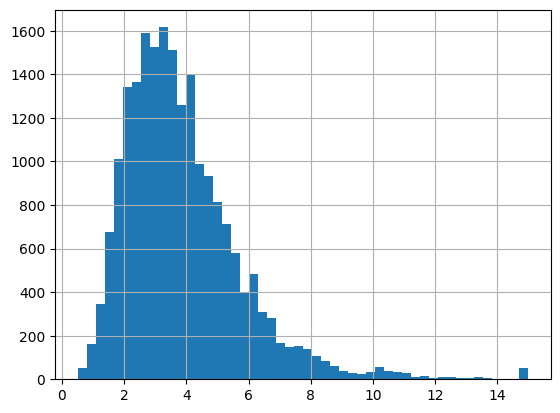

In [ ]:
_ = housing["median_income"].hist(bins=50)

Pandas' `pd.cut` function allows us to create a new column segmenting into categories. In this case, we're going to create 5 categories, separating into blocks of 1.5 (except the last one which will group the entire thick tail on the right), and we're going to use the `value_counts` function to see how many values are in each category.

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf], # Secuencia de límites de los contenedores
                               labels=[1, 2, 3, 4, 5])

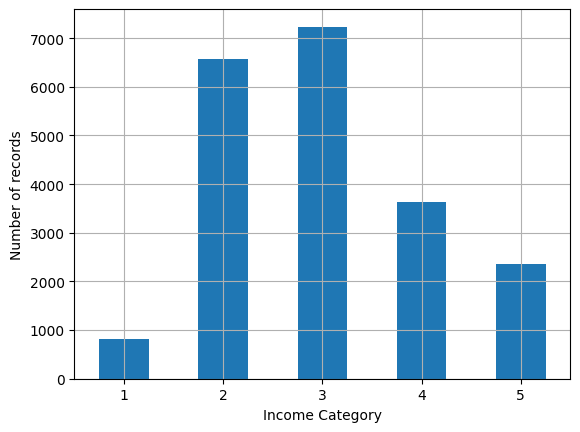

In [ ]:
import matplotlib.pyplot as plt

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of records")
plt.show()

We can use scikit-learn's `train_test_split` function again, but this time with the `stratify` parameter indicating the column we want to use to stratify the sampling.

In [ ]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"],random_state=42)

It is observed that the test set generated using stratified sampling has a much more representative amount of samples in each stratum of the total population, despite being random.

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

Now we can show a complete dataframe with the random and stratified sampling errors, and see that the stratified sampling error is much smaller.

In [ ]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data) # proportion of values in each income_cat

train_set, test_set = train_test_split(housing, test_size=0.2) # re-executing this cell we can see the variation in random split

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing), # proportion of values in each income_cat in the original dataset
    "Stratified %": income_cat_proportions(strat_test_set), # proportion in the stratified test set
    "Random %": income_cat_proportions(test_set), # proportion in the randomly generated test set
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] / compare_props["Overall %"] - 1) # stratified error with respect to original
compare_props["Rand. Error %"] = (compare_props["Random %"] / compare_props["Overall %"] - 1) # random error with respect to original
(compare_props * 100).round(2) # convert all values to percentage with two decimals

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,3.95,0.36,-0.85
2,31.88,31.88,32.41,-0.02,1.66
3,35.06,35.05,34.45,-0.01,-1.74
4,17.63,17.64,16.88,0.03,-4.23
5,11.44,11.43,12.31,-0.08,7.54


Since we will no longer need the `income_cat` variable (it was only used as a help for stratifying), we can remove it from both generated sets.

In [ ]:
strat_train_set.drop("income_cat", axis=1, inplace=True)
strat_test_set.drop("income_cat", axis=1, inplace=True)

strat_train_set.head().T

,12655,15502,2908,14053,20496
longitude,-121.46,-117.23,-119.04,-117.13,-118.7
latitude,38.52,33.09,35.37,32.75,34.28
housing_median_age,29.0,7.0,44.0,24.0,27.0
total_rooms,3873.0,5320.0,1618.0,1877.0,3536.0
total_bedrooms,797.0,855.0,310.0,519.0,646.0
population,2237.0,2015.0,667.0,898.0,1837.0
households,706.0,768.0,300.0,483.0,580.0
median_income,2.1736,6.3373,2.875,2.2264,4.4964
median_house_value,72100.0,279600.0,82700.0,112500.0,238300.0
ocean_proximity,INLAND,NEAR OCEAN,INLAND,NEAR OCEAN,<1H OCEAN


## Data Leakage

**Data leakage** is one of the most critical methodological errors in machine learning. It occurs whenever information from outside the training dataset is used to create the model. This includes not only the fitting of model parameters (weights), but also preprocessing decisions, hyperparameter tuning, and algorithm selection.

The consequence of data leakage is always the same: the reported performance metrics become **optimistically biased**, meaning they overestimate how well the model will perform on truly unseen data. A model affected by leakage may look excellent during development but fail dramatically in production.

Data leakage can be classified into three main types:

### 1. Feature Leakage (Preprocessing Contamination)

This occurs when statistics computed from the entire dataset (including test data) are used to transform features during preprocessing. The model indirectly "sees" properties of the test set through these statistics.

**Example**: Computing the mean and standard deviation for standardization (Z-score normalization) using the entire dataset, then applying it to both train and test sets.

```python
# WRONG: Leakage through preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)  # Fitted on ALL data, including test!
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# CORRECT: Fit only on training data
scaler = StandardScaler()
scaler.fit(X_train)  # Fitted ONLY on training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
```

This is why scikit-learn pipelines are essential: they ensure that all preprocessing steps are fitted only on training data during cross-validation.

### 2. Target Leakage

This occurs when a feature contains information that is derived from (or strongly correlated with) the target variable in a way that would not be available at prediction time in production.

**Example**: Predicting whether a patient will develop a disease, using a feature like "prescribed_medication_X" that is only given *after* the diagnosis. The model learns the correlation, but in production, new patients won't have this feature yet.

**Another example**: In fraud detection, using "account_flagged_for_review" as a feature—this flag may only exist *because* fraud was already detected.

Target leakage is particularly insidious because:
- The model may achieve near-perfect accuracy during training
- The leaked feature often has very high predictive power (because it's essentially encoding the answer)
- It only becomes apparent when the model fails in production

**Prevention**: Carefully audit each feature and ask: "Would this information be available at the moment of prediction in production?"

### 3. Model Selection Leakage

This occurs when the test set is used to compare models, tune hyperparameters, or make any decision that influences the final model. Even though the test data is never directly used for training, the feedback from test performance guides the model selection process.

**Example**: Training several models (Linear Regression, Decision Tree, Random Forest), evaluating each on the test set, and choosing the one with the lowest test error. Then reporting that test error as the expected performance.

**The problem**: The reported test error is no longer an unbiased estimate of generalization performance. By selecting the model that performs best on *this specific* test set, we are implicitly fitting to the test data. This is often called **overfitting to the test set**.

**The solution**: Use a **three-way split**:
- **Training set**: To fit model parameters
- **Validation set**: To compare models and tune hyperparameters  
- **Test set**: To evaluate the final model **only once**, at the very end

Alternatively, use **cross-validation** on the training set to compare models without touching the test set at all. The test set should remain in a "vault" until the final evaluation.

### Summary: Preventing Data Leakage

| Type | What leaks | Prevention |
|------|-----------|------------|
| **Feature Leakage** | Test set statistics into preprocessing | Use pipelines; fit transformers only on training data |
| **Target Leakage** | Future/derived information into features | Audit features for temporal/causal validity |
| **Model Selection Leakage** | Test performance into model choice | Use validation set or cross-validation; test only once |

The golden rule: **the test set must simulate truly unseen data**. Any information flow from test to training—whether through features, preprocessing, or feedback—violates this principle and invalidates the performance estimate.

## Data Loading Utility

The stratified train/test split demonstrated in this notebook is consolidated into a reusable function in [`utils/load_california.py`](utils/load_california.py). This function:

1. Loads the housing data from CSV
2. Creates income categories for stratification
3. Performs stratified train/test split
4. Removes the temporary `income_cat` column
5. Separates features (X) and target (y)

Subsequent notebooks import this function to ensure consistent data loading:

```python
from utils.load_california import load_housing_data

X_train, X_test, y_train, y_test = load_housing_data()
```